In [2]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import io
import os
import re
import string
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam

(2000,)


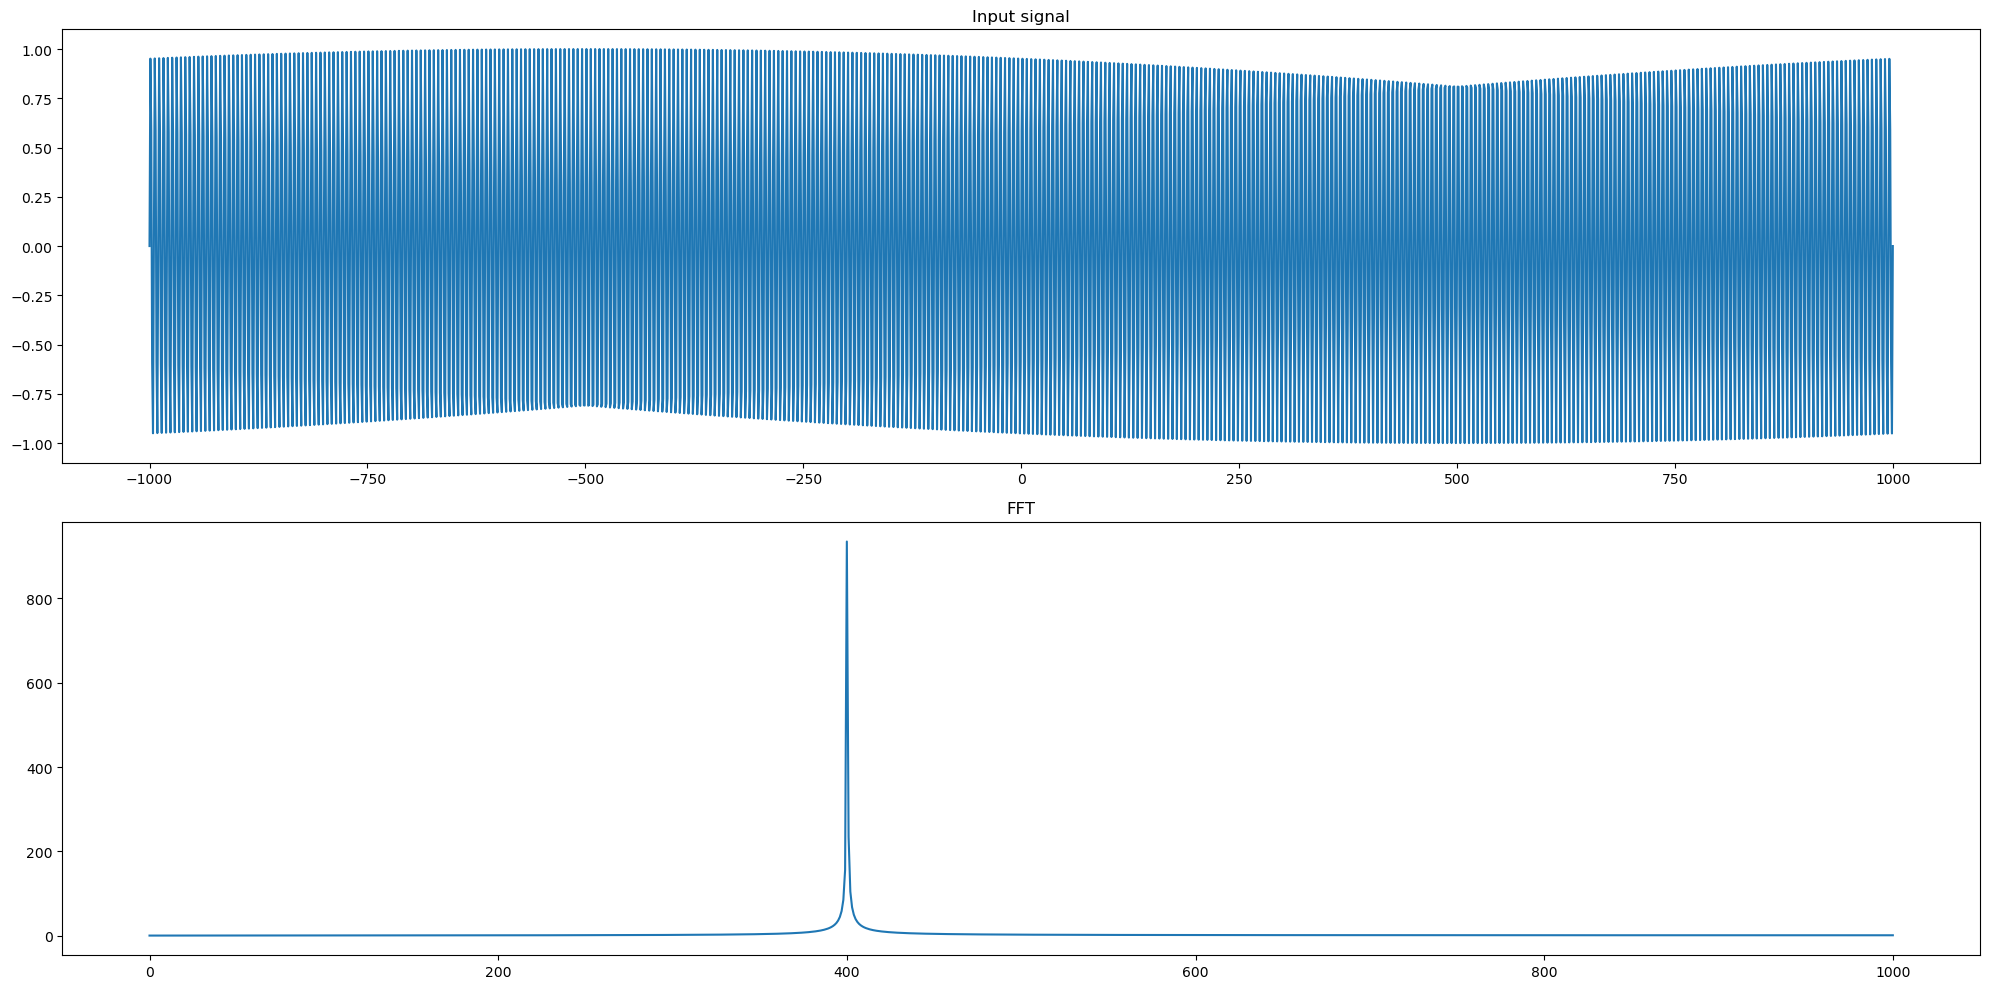

In [21]:
fig, axis = plt.subplots(2, figsize=(20, 10))

L=2000

x= tf.linspace(-L//2, L//2, L)
signal=tf.math.sin(x*2*np.pi*400)
print(signal.shape) 

axis[0].plot(x, signal)
axis[0].set_title("Input signal")

fft = tf.signal.rfft(signal)

axis[1].plot(tf.abs(fft))

axis[1].set_title("FFT")


plt.tight_layout()

In [22]:
BATCH_SIZE=32
LR=1e-4
FRAME_LENGTH=255
FRAME_STEP=128
N_EPOCHS=100

In [ ]:
audio_binary=tf.io.read_file("dataset/LJSpeech-1.1/wavs/LJ001-0001.wav")
audio,_=tf.audio.decode_wav(audio_binary)
waveform=tf.squeeze(audio,axis=-1)
waveform=tf.cast(waveform,tf.float32)
signal=waveform
print(signal.shape)

In [ ]:
fig,axis=plt.subplots(4,figsize=(20,10))

L=2000
x=tf.linspace(-L//2,L//2,L)
print(signal.shape)
axis[0].plot(signal)
axis[0].set_title("Input Signal")

fft=tf.signal.rfft(signal)

axis[1].plot(tf.abs(fft))
axis[1].set_title("fft")


spec=tf.signal.stft(signal,frame_length=1024,frame_step=512,)
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[2].pcolormesh(X,Y,power_spec)
axis[2].set_title("Spectrogram-1")


spec=tf.signal.stft(signal,frame_length=256,frame_step=128, )
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[3].pcolormesh(X,Y,power_spec)
axis[3].set_title("Spectrogram-2")


plt.show()


In [ ]:
audio_text={}

In [ ]:
csv_path="dataset/LJSpeech-1.1/metadata.csv"
with open(csv_path, encoding="utf-8") as f:
  for line in f:
    i=line.strip().split("|")[0]
    text=line.strip().split("|")[1]
    audio_text[str(i)]=text

In [ ]:
filepaths=["/content/dataset/LJSpeech-1.1/wavs/"+filename+".wav" for filename in list(audio_text.keys())]
transcriptions=[audio_text[str(filename)].lower() for filename in list(audio_text.keys())]
print(len(filepaths))
print(len(transcriptions))

In [ ]:
dataset=tf.data.Dataset.from_tensor_slices((filepaths,transcriptions))

In [ ]:
for i in dataset.take(1):
  print(i)

In [ ]:
def decode_audio(audio_binary):
    audio,_=tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio,axis=-1)

In [ ]:
vocabulary=[""]+[chr(i) for i in range(97,97+26)]+[".",",","?"," "]
print(vocabulary)
print(len(vocabulary))

In [ ]:
def get_label(label,):
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    label=tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")(label)
    return label

In [ ]:
def get_spec(filepath,label):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)
  spectrogram=tf.abs(spectrogram)
  label=get_label(label)
  return tf.expand_dims(spectrogram,axis=-1),label

In [ ]:
processed_dataset = (
    dataset.map(get_spec, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
train_dataset=processed_dataset.take(int(0.95*len(processed_dataset)))
val_dataset=processed_dataset.skip(int(0.95*len(processed_dataset)))

In [ ]:
for i,j in train_dataset.take(1):
  print(i,j)

In [ ]:
normalization=tf.keras.layers.Normalization()

In [ ]:
input_spectrogram=Input((None,129,1), name="input")

x=normalization(input_spectrogram)
x=Conv2D(32,kernel_size=[11,41],strides=[2,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)
x=Conv2D(64,kernel_size=[11,21],strides=[1,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)

x=Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)


output=Dense(len(vocabulary)+1, activation="softmax")(x)

model = tf.keras.Model(input_spectrogram, output, name="DeepSpeech_2_Inspired")
model.summary()

In [ ]:
tf.__version__

In [ ]:
def ctc_loss(y_true,y_pred):
  batch_size=tf.shape(y_pred)[0]
  pred_length=tf.shape(y_pred)[1]
  true_length=tf.shape(y_true)[1]

  pred_length=pred_length*tf.ones([batch_size,1],dtype=tf.int32)
  true_length=true_length*tf.ones([batch_size,1],dtype=tf.int32)

  return tf.keras.backend.ctc_batch_cost(y_true,y_pred,pred_length,true_length)

In [ ]:
model.compile(
    loss=ctc_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
)

In [ ]:
history=model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=N_EPOCHS
)

In [ ]:
def get_spec_inference(filepath):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)

  spectrogram=tf.abs(spectrogram)

  return tf.expand_dims(spectrogram,axis=-1)

In [ ]:
test_path="LJ001-0005.wav"

In [ ]:
spectrogram=get_spec_inference(test_path)
print(spectrogram.shape)
out=tf.argmax(model.predict(tf.expand_dims(spectrogram,axis=0))[0],axis=1)

In [ ]:
out

In [ ]:
out_list=[vocabulary[i] if i!=31 else "[LINK]" for i in out]
out_str="".join(out_list)

In [ ]:
print(out_str)

In [ ]:
def decode(y_pred):
  batch_size=tf.shape(y_pred)[0]
  print(tf.shape(y_pred))

  pred_length=tf.shape(y_pred)[1]
  pred_length*=tf.ones([batch_size,],dtype=tf.int32)

  y_pred=tf.one_hot(y_pred,len(vocabulary)+1)
  output=tf.keras.backend.ctc_decode(y_pred,input_length=pred_length,greedy=True)[0][0]

  out=[vocabulary[i] for i in output[0]]
  return ''.join(out)

In [ ]:
print(decode(tf.expand_dims(out,axis=0)))